# Self-Driving Car Engineer Nanodegree

## **Vehicle detection and tracking** 

![Cover](./writeup_imgs/cover.jpg)

---

## Overview

In this project, your goal is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car. The test images and project video are available in the [project repository](https://github.com/miguelangel/sdc--vehicle-detection-and-tracking). 

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. A great writeup should include the [rubric](https://review.udacity.com/#!/rubrics/513/view) points as well as your description of how you addressed each point. You should include a detailed description of the code used in each step (with line-number references and code snippets where appropriate) and links to other supporting documents or external references. You should also include images in your writeup to illustrate how your code works.


## Goals/Steps

The goals / steps of this project are the following:
* Import and initialize the packages needed in the project.
* Implement a function that computes Histogram of Oriented Gradients (HOG) features from an image.
* Implement a function that computes binned color features from an image.
* Implement a function that computes color histogram features from an image.
* Combine the previous feature extractors on a function
* Extract features from the dataset, and split them in training and testing sets
* Normalize the features 
* Train a Linear SVM classifier.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Step 0: Import and initialize the packages needed in the project

In [1]:
import cv2
import glob
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from moviepy.editor import VideoFileClip
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# My humble tribute to Michael Jordan, 
# the best basketball player ever.
np.random.seed(23)

%matplotlib inline

### Step 1: Implement a function that computes Histogram of Oriented Gradients (HOG) features from an image.

In [2]:
# This function returns HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element
def hog_feat(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True):
    """
    Function accepts params and returns HOG features (optionally flattened)
    and an optional matrix for visualization. Features will always be the
    first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    return_list = hog(img, orientations=orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block),
        block_norm='L2-Hys', transform_sqrt=False, 
        visualise=vis, feature_vector=feature_vec)
    
    if vis:
        hog_features = return_list[0]
        hog_image = return_list[1]
        
        return hog_features, hog_image
    else:
        hog_features = return_list
        
        return hog_features

In [3]:
# Helper method to plot two images side by side
def plt_images(img_1, title_1, img_2, title_2, cmap='gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')

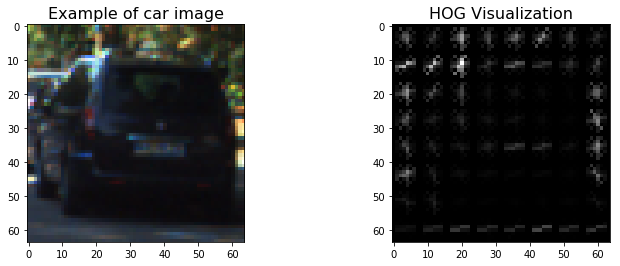

In [6]:
# Run the function on car images
#car_images = glob.glob('./data/vehicles_smallset/*/*.jpeg')
car_images = glob.glob('./data/vehicles/*/*.png')

# Display a random car image and its HOG visualization,
ind = np.random.randint(0, len(car_images))

# Read in the image and convert it to grayscale
car_img = mpimg.imread(car_images[ind])
gray_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = hog_feat(gray_img, orient=9, pix_per_cell=8,
                                    cell_per_block=2, vis=True, feature_vec=False)

# Plot results
plt_images(car_img, 'Example of car image', hog_image, 'HOG Visualization')

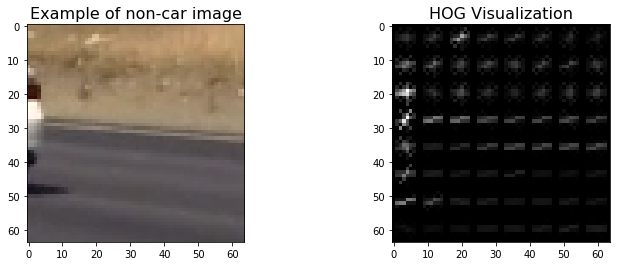

In [7]:
# Run the function also on non-car images
#non_car_images = glob.glob('./data/non-vehicles_smallset/*/*.jpeg')
non_car_images = glob.glob('./data/non-vehicles/*/*.png')

# Display a random car image and its HOG visualization,
ind = np.random.randint(0, len(non_car_images))

# Read in the image and convert it to grayscale
non_car_img = mpimg.imread(non_car_images[ind])
gray_img = cv2.cvtColor(non_car_img, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = hog_feat(gray_img, orient= 9, pix_per_cell= 8,
                               cell_per_block= 2, vis=True, feature_vec=False)

hog_features = hog_feat(gray_img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True)


# Plot results
plt_images(non_car_img, 'Example of non-car image', hog_image, 'HOG Visualization')

### Step 2: Implement a function that computes binned color features from an image.

In [8]:
# This function computes binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

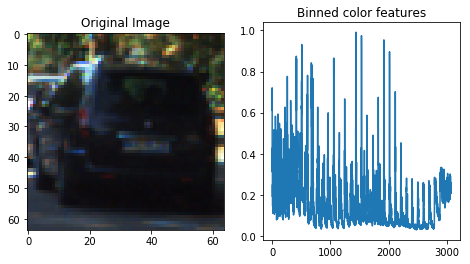

In [9]:
# Run the function
spatial_features = bin_spatial(car_img, size=(32, 32))

# Plot results
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(car_img)
plt.subplot(132)
plt.title('Binned color features')
plt.plot(spatial_features)

### Step 3: Implement a function that computes color histogram features from an image.

In [10]:
# This function computes color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

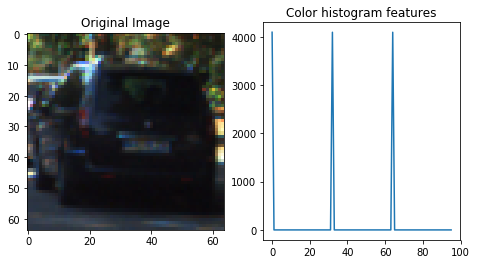

In [11]:
# Run the function
hist_features = color_hist(car_img, nbins=32, bins_range=(0, 256))

# Plot results
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(car_img)
plt.subplot(132)
plt.title('Color histogram features')
plt.plot(hist_features)

### Step 4: Combine the previous feature extractors on a function

In [12]:
# This function extracts features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        img = mpimg.imread(file)

        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        else: feature_img = np.copy(img)
            
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_img, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_img, nbins=hist_bins, bins_range=hist_range)
        
        # Apply hog_feat() to get hog features
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_features = hog_feat(gray_img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    
    # Return list of feature vectors
    return features

### Step 5: Extract features from the dataset, and split them in training and testing sets

#car samples: 8792
#non_car samples: 8968


In [48]:
# Print the results
print ("The dataset is well balanced:")
print ("- Number of samples in car_images:", len(car_images))
print ("- Number of samples in non_car images:", len(non_car_images))
print ()
print ("Number of samples:")
print ("- In training set:", X_train.shape[0])
print ("- In testing set:", X_test.shape[0])
print ()
print ("X_train before normalization:")
print (X_train)

The dataset is well balanced:
- Number of samples in car_images: 8792
- Number of samples in non_car images: 8968

Number of samples:
- In training set: 14208
- In testing set: 3552

X_train before normalization:
[[ 1.34018858  1.57506148  2.19031452 ... -0.27904728 -0.26676046
  -0.18584212]
 [-0.63309992 -0.73115083 -0.77699868 ...  2.06800435  2.0058888
   4.5528597 ]
 [-0.5539926  -0.50626205 -0.59209195 ... -0.28883833 -0.29940463
  -0.19082693]
 ...
 [-0.47488527 -0.4489374  -0.51724875 ...  1.28593898 -0.44487802
  -0.4897381 ]
 [ 0.54911521  0.46825602  0.31483159 ...  0.44704515  0.88425547
   0.27397875]
 [ 1.23910693  1.68089176 -0.0373717  ... -0.28959335 -0.42316652
  -0.48734041]]


In [42]:
# Extract features from car and non_car datasets
car_features = extract_features(car_images, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
non_car_features = extract_features(non_car_images, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))

# Create features and labels dataset
features = np.vstack((car_features, non_car_features)).astype(np.float64)
car_labels = np.full((len(car_features)), 1)
non_car_labels = np.full((len(non_car_features)), 0)
labels = np.concatenate((car_labels, non_car_labels))

# Split our dataset in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=23)

# Print the results
print ("The dataset is well balanced:")
print ("{0:3}#car_images:", len(car_images))
print ("{0:3}#non_car images:", len(non_car_images))
print ()
print ("Number of samples:")
print ("- In training set:", X_train.shape[0])
print ("- In testing set:", X_test.shape[0])
print ()
print ("X_train before normalization:")
print (X_train)

KeyboardInterrupt: 

### Step 6: Normalize the features

In [38]:
# Fit the scaler on the training set
scaler = StandardScaler().fit(X_train)

# Transform training and testing sets
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

# Print the results
print("X_train after normalization:")
print(X_train)
print()
scaled_features = np.vstack((X_train, X_test))
print("Features mean after normalization: {:.2f}".format(np.mean(scaled_features)))
print("Features variance after normalization: {:.2f}".format(np.var(scaled_features)))


X_train after normalization:
[[ 1.34018858  1.57506148  2.19031452 ... -0.27904728 -0.26676046
  -0.18584212]
 [-0.63309992 -0.73115083 -0.77699868 ...  2.06800435  2.0058888
   4.5528597 ]
 [-0.5539926  -0.50626205 -0.59209195 ... -0.28883833 -0.29940463
  -0.19082693]
 ...
 [-0.47488527 -0.4489374  -0.51724875 ...  1.28593898 -0.44487802
  -0.4897381 ]
 [ 0.54911521  0.46825602  0.31483159 ...  0.44704515  0.88425547
   0.27397875]
 [ 1.23910693  1.68089176 -0.0373717  ... -0.28959335 -0.42316652
  -0.48734041]]

Features mean after normalization: 0.00
Features variance after normalization: 0.99


### Step 7: Train a Linear SVM classifier